# Steps for building Machine Learning Projects

This sample project demostrates various steps involve in a standard end-to-end machine learning project.

In this sample project we will analyse a Housing Price Prediction dataset, clean it and prepare it for machine learning algorithms. Then appling machine learning (regression) models and evaluate our model on the validation sets. Then we we will fine-tune our model by trying out various possibilities. And when the model is ready, we will test it in the test set and will put that model to the production.

## Exploring the Housing Dataset 

In [1]:
##This method fetches the dataset from the server 
##saves it into a directory (/datasets/housing)and extract it
import sys
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT =  "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
            os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
#This method loads the data from csv file into a pandas DataFrame object

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
#Below is the sample script to fetch the data and load it as pandas DataFrame

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
#This lists all the information about columns in the DataFrame
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#counting values of various ocean proximities
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
#showing summary of numerical attributes 
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


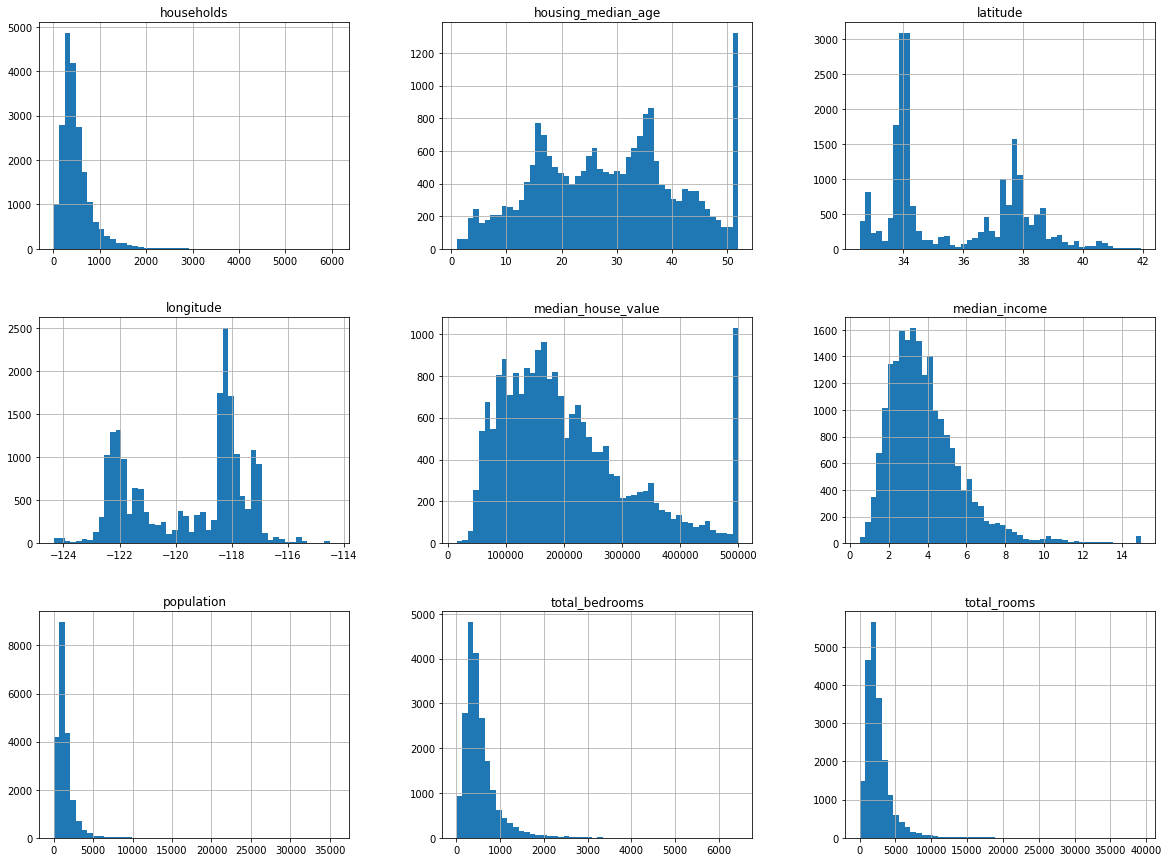

In [7]:
#plotting Histograms of housing DataFrame
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Creating a Test Set

In [8]:
#creating a test set by diving the given dataset randomly into two parts based on given test_ratio
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


But! the above approach will provide different test dataset everytime we run the script
here are few solutions for that
 
 - save the test set on first run and then load in subsequent runs
 - set the random number generator's seed (ex- np.random.seed(42)) before calling np.random.permutation()

but the above solutions will break when we'll download the updated dataset, for that, we can

 - use each instance's unique identifier to decide whether it should go in test set or not
   for ex- computing hash of each instance's unique identifier and put the instance in test
   set if the last byte of hash is > 51 (~ 20% of 256)
   this ensures that test set will remain consistent accross multiple runs, even if we refresh the dataset

In [9]:
#Below is the possible implementation of the above explained approach
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

#using row index as id 

housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set), "train +", len(test_set), "test")

16362 train + 4278 test


using row index as unique identifier is not a good example as the ids may change when some element
is removed or added, hence we use some kind of a stable identifier such as latitude and latitude combination

In [10]:
#using longitude, latitude combination as id

housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print(len(train_set), "train +", len(test_set), "test")

16267 train + 4373 test


In [11]:
#Using sklearn makes things easier
#the following code does the same thing as split_train_test() method implemented above
#it also allows us to set random generator seed as explained previously

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


So far we have discussed purely random sampling methods, but is the dataset is not large enough
(specially related to the number of attributes) then it runs the risk of introducing sampling bias

Remember- Survey company decides to call 1000 people to ask them few questions, then they choose the 
          people in such a way, that those people are representative of the whole population
          
This kind of sampling method is known as **Stratified Sampling**, and where the data is divided into homogeneous subgroups called **strata** and the right number of instanes is sampled from each stratum to gaurantee that the test set is representative of the overall population

In [12]:
#Suppose median income is very important attribute to predict median housing prices
#then we may want to ensure that test set is representative of various categories of 
#incomes in the whole dataset

#first we need to convert this continuous numerical attribute to categorical attribute

housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)


In [13]:
#now we can do stratified sampling based on income category using Scikit-Learn's StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

split =  StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [14]:
#now removing income_cat attribute from both training and testing sets

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Putting the Test Set Aside  and Visualizing Data

In [15]:
#now making copy of training set in housing variable
housing = strat_train_set.copy()

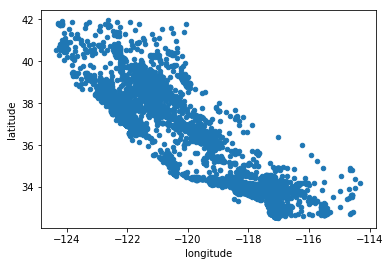

In [16]:
# Scatterplot of geographical information

housing.plot(kind="scatter", x="longitude", y="latitude")

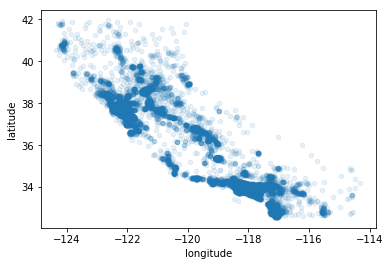

In [17]:
# Scatterplot of geographical information with alpha to clearly see high density attributes 

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

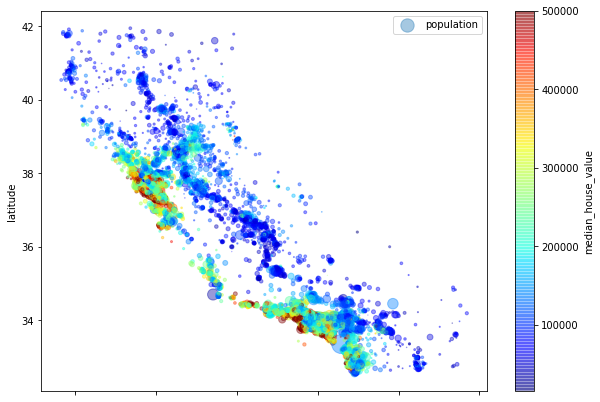

In [18]:
#Visualizing hosuing prices with district population

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing["population"]/100, label="population",figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True
)
plt.legend()

### Looking for Correlations 

In [19]:
corr_matrix =  housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe140da0b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7efe1d5ff978>]], dtype=object)

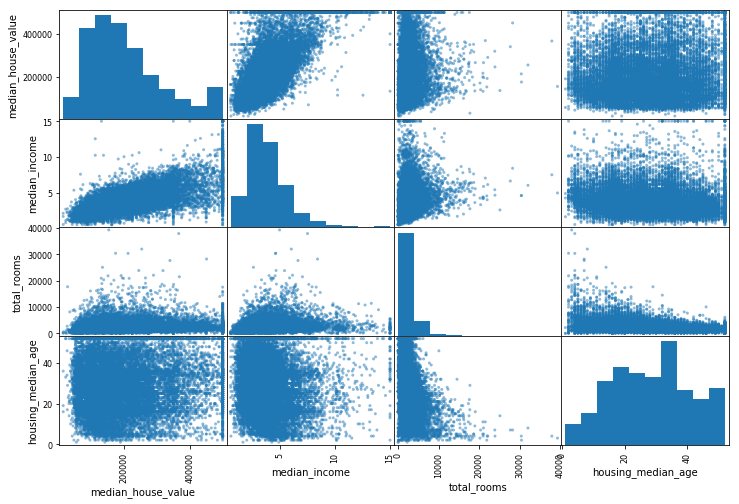

In [20]:
#checking correlation using  scatter plots using Pandas scatter_matrix function

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))

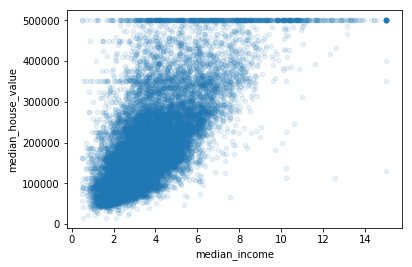

In [21]:
#the above plots when each varibale is plotted to itself is drawn as histograms and plotting a variable to
#itself will not give any meaningful results

#the most promising attribute to predict house price is median_income, let's zoom into that a bit

housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [22]:
""" Now experimenting with attribute combinations

    we may find that total number of rooms in a district is not very useful feature, is we don't know 
    how many households are there, and similary we can check other attributes
"""

#housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
#housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
#housing["population_per_household"] = housing["population"]/housing["households"]

#corr_matrix = housing.corr()
#corr_matrix["median_house_value"].sort_values(ascending=False)

" Now experimenting with attribute combinations\n\n    we may find that total number of rooms in a district is not very useful feature, is we don't know \n    how many households are there, and similary we can check other attributes\n"

## Data Cleaning

Most Machine Learning Algorithms cannot work with missing features, so le's take care of them. We noticed that total_bedrooms attribute has some missing values, to solve that, we have three options:
    
    - Get rid of corresponding districts
    - Get rid of the whole attribute
    - Set the values to some value (zero, the mean, the median, etc.)

In [23]:
#first separate predictors and labels (as we don't want to apply same transformation to both)

housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#we can easily accomplish them by using DataFrames' dropna(), drop(), and fillna() methods
"""
#option 1 housing.dropna(subset=["total_bedrooms"]) 

#option 2 housing.drop("total_bedrooms", axis=1) 

#option3 median =  housing["total_bedrooms"].median() 
#housing["total_bedrooms"].fillna(median, inplace=True)
"""

'\n#option 1 housing.dropna(subset=["total_bedrooms"]) \n\n#option 2 housing.drop("total_bedrooms", axis=1) \n\n#option3 median =  housing["total_bedrooms"].median() \n#housing["total_bedrooms"].fillna(median, inplace=True)\n'

In [24]:
#Scikit-Learn provider a handy class to take care of missing values: Imputer, which can be used as

from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
#since median can only be computed on numerical attributes, we need to create a copy of data without 
#the text-attribute ocean_proximity
housing_num = housing.drop("ocean_proximity", axis=1)
#now we can fir the imputer instance on the training data
imputer.fit(housing_num)

imputer.statistics_
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


In [25]:
#now we can use this trained imputer to transform the training set by replacing the missing
# values by learned medians

X = imputer.transform(housing_num) #the result is plane numpy array containing transformed features

housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


### Scikit-Learn Design 

The Scikit-Learn is remarkably well designed. The main design principles are:

- **Consistency** : All Objects share a consistent and simple interface 
    - *Estimators* : Any object that can estimate some parameters based on some dataset is an estimator (ex- imputer)
    - *Transformers* : Some estimators can also transform a dataset, these are called transformers (ex- imputer) 
    - *Predictors*   : Some estimators are capable to make predictions given a dataset, they are called predictors (ex- *LinearRegression* model)


- **Inspection** : All estimator's hyperparameters are accessible directly via public instance variables (e.g.                    imputer.strategy) and all estimator's learned parameters are also accessible via public instance variables with an underscore suffix (ex- imputer.statistics_)


- **Nonproliferation of classes** : Datasets are represented by Numpy arrays or Scipy Sparse matrixes, instead of Homogeneous Classes. Hyperparameters are just Python strings or numbers


- **Composition** : Existing building blocks can be reused as much as possible. For example, it is easy to create a Pipeline estimator from an arbitrary sequence of transformers followed by a final estimator


- **Sensible defaults** : Scikit-Learn providers reasonable default values for most parameters, making it easy to create a baseline working system quickly

### Handling Text and Categorical Attributes 

Most machine learning algorithms prefer to work with numbers, so it's better to convert categorical attributes to numerical attributes. 

In [26]:
#Scikit-Learn provides a transformer for thi task called LabelEncoder

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)

#it'll print the mapping learned
print(encoder.classes_)

[0 0 4 ..., 1 0 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


One issue with this approach is that ML Algorithms assume that two nearby values are more similar than two distant values (which is obviously not the case as they all represent a category). To  fix this issue, a common solution is to create **one-hot encoding**.

In [27]:
#Scikit-Learn provides a OneHotEncoder to convert integer categorical values into one-hot vectors.

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot #this is a SciPy sparse matrix
#converting into to NumPy Array
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [28]:
# We can apply both tranformations
#    - from text categories to integer categories
#    - from integer categories to one-hot vectors
# in one shot using LabelBinarizer class provided by Scikit-Learn

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot #it return a numpy array by default

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

#### Custom Transformers

We can also implement out custom Transformers in Scikit-Learn. In order for our transformer to seamlessly work with Scikit-Learn functionalities (such as pipelines). Since Scikit-Learn reilies on duck typing(not inheritance), so we just need to create a class and implement three methods: fit(), transform() and fit_transform().
 - We can get the last one for free by simply adding TransformerMixin as a base class
 - Also, if we add BaseEstimator as a base class (and avoid *args and * *kwargs in you constructor), we'll get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparamer tuning. 

In [29]:
#Example of Custom Transformer that implements Combined Attributes, as we discussed earlier
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args and **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self #nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombineAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values) #returns numpy array

### Feature Scaling

Machine Learning Attributes don't perform well when the input numerical attributes have very different scales. There are two common ways to get all attributes to have same scale:
 
 - **_Min-max_** : In this, values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus min. Scikit-Learn provides a trasnformer called MinMaxScaler for this, which also has a feature range for that lets we change the range if we don't want 0-1 for some reason.
 - **_Standardization_** : First it subtracts the mean value (so that the syandardized values always have a zero mean) and then it divides the variance so that the resulting distribution has a unit variance. Scikit-Learn provides a transformer called StandardScaler for standardization
 
Unlike min-max scaling, standardization doesn't bound the values to a specific range, which may be a problem for some algorithms (e.g. neural network often expect an input value ranging from 0 to 1). However standardization is much less effected by outliers. For example, suppose a district had median income equal to 100, the min-max would then crush all the other values from 0-15 down to 0-0.15, whereas standardization would not be much affected. 

### Transformation Pipelines

As we can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit Learn provides the **Pipeline** class to help with the sequences of transformations.

In [30]:
#Example of Pipeline for Numerical Attributes

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_addr', CombineAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [31]:
# Custom transformer for feed a PandasDataFrame directly into our pipeline, 
# instead of extracting numerical attributes in the NumPy Array

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [32]:
#Separate Pipelines for Numerical and Categorical Attributes

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_addr', CombineAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

#this is workaround for LabelBinarizer, as it is not intended to work as explained with 
#pipeline in the tutorial
from sklearn.base import BaseEstimator, TransformerMixin
class LabelBinarizer_new(TransformerMixin, BaseEstimator):
    encoder = LabelBinarizer()
    def fit(self, X, y = 0):
        encoder.fit(X)
        return self
    def transform(self, X, y = 0):
        result = encoder.transform(X)
        return result;
    
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer_new()),
])

In [33]:
#Joining both the piplines using FeatureUnion

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

#running the whole pipeline
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
housing_prepared.shape

(16512, 16)

## Select and Train a Model 

We framed the problem, 
we got the data and explored it, 
we sampled a training set and testing set, 
and we wrote transformation pipelines to clean up and prepare our data for Machine Learning Algorithms automatically. We are now ready to select and train a Machine Learning Model 

### Training and Evalutating on the Training Set

We'll train Linear Regression Model for the given data, as shown below

In [34]:
#Training a Linear Regression Model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We now have a working Linear Regression Model, Let's try it out on few instances from the training set,

In [35]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
#full_pipeline = full_pipeline.fit(housing)
some_data_prepared = full_pipeline.transform(some_data)
#predicted_labels
print("Predictions:", lin_reg.predict(some_data_prepared))
#actual labels
print("Labels:", list(some_labels))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Now, our model is able to predict values, but the predictions are not exactly accurate (e.g. first prediction is off by 40%). Let's measure the regression model's RMSE on the whole training set using Scikit-Learn's mean_squared_error function:

In [36]:
#calculating RMSE of the training set
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

Most of districts' median_housing_values range between $120,000 and $265,000, so a typical prediction error of $68,628 is not very satisfying. This is an example of underfitting the training data. This happens when the features do not provide enough information to make good predictions, or that the model is not powerful enough.
We can solve the problem of underfitting by,
 - Selecting a more powerful model
 - Feeding training algorithm with better features
 - Reducing the contraints on the model

This model is not regularized to this rules out the last option. We could try to add more features, but first let's try a more complex model to see how it does.

In [37]:
#Training a DecisionTreeRegressor on the given dataset
# - It is capable of finding complex non-linear relationships in the data
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

#now evaluating the model on training set
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The above trained model gives no prediction error at all, this means the model has badly overfitted the data. To be sure, we'll use the art of training set for training, and part for model validation. This will allow us to evaluate the model for overfitting.

### Better Evaluation Using Cross-Validation

Scikit-Learn provides a cross-validation feature. The following code performs the K-fold cross-validation: it randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different for evaluation every time and training on the other 9 folds.
The result is an array containing 10 validation scores:

In [38]:
#Model cross-validation using Scikit-Learn cross_val_score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

#printing the results
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 67649.26921779  69113.59177095  71824.35934411  70236.75766976
  72168.44719549  75165.99707216  71051.70301142  69957.41519011
  77044.659542    69049.00548166]
Mean: 71326.1205495
Standard Deviation: 2741.15375648


Let's compute the same cross-validation scores for the Linear Regression model,

In [39]:
#Computing cross-validation scores for Linear Regression Model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard Deviation: 2731.6740018


Hence, we can observe that the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression Model. Let's try another model: RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. 


Building on the top of other model is called **_Ensemble Learning_**, and it is often a great way to push ML alorithms even further. 

In [40]:
#training RandomForestsRegressor on the given dataset
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

#evaluating model on training set
housing_predictions = forest_reg.predict(housing_prepared)
tree_rmse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_rmse)
print("Training set validation score", tree_rmse)

#calculating cross-validation scores
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rsme_scores = np.sqrt(-forest_scores)
display_scores(forest_rsme_scores)

Training set validation score 22032.0856196
Scores: [ 51675.39200562  49479.57522268  51702.05772517  54869.79234774
  53034.59593915  57572.40502277  52372.82500999  49923.99362584
  56284.59338399  51786.9247527 ]
Mean: 52870.2155036
Standard Deviation: 2493.66533191


This is a good improvement in our predictions, but as we can see that the scores on the training set are much lower than the validation sets, meaning the model is still overfitting the training set.


#### Saving Trained Model in a File

**Note:** To experiment with different models, we can save the models to come back to an model we want. We can save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps actual predictions as well. This will allow us to compare scores accross model types, and compare the types of errors they make. We can easily save Scikit-Learn models by using Python's **pickel** module, or using **sklearn.externals.joblib**, which is more efficient at serializing large NumPy Arrays:

In [41]:
#example code to save the trained model
from sklearn.externals import joblib

#saving the model
''' joblib.dump(mymodel,"my_model.pkl") '''

# and later ... we can load the model simply as
''' my_model_loaded = joblib.load("my_model.pkl") '''

' my_model_loaded = joblib.load("my_model.pkl") '

## Fine Tuning Model 

Now, let's assume we have shortlist of promising models. We can now fine-tune them. Let's look at a few ways we can do that:

### Grid Search

One way to do that would be to fiddle with the hyperparameters manually, until we find a great combination of hyperparameter values. This would be very tedius work, and we may not have time to explore many combinations.

Instead we should get Scikit-Learn's GridSearchCV to search for us. We just need to tell it, which hyperparameters we want to experiment with and which values to try out, and it'll evaluate all the possible combinations of hyperparameter values, using cross-validation so as to find the values which gives best results.

In [42]:
#Finding best Hyperparamter values for RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#parameters and their values to try out
param_grid= [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]

forest_reg = RandomForestRegressor()

#creating a grid search intance & setting up parameters
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error")

#trying out all the given hyperparameter values
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

**Note:** When we have not clue which hyperparamter values to try out, then a simple approach to try out consecutive powers of 10 or a smaller number if we want more fine grained results 

The above GridSearchCV will evalute all the combinations of provided parameters, i.e. 12+6 and each time it'll train the model 5 times (as cv=5), hence total there will be 18*5= 90 rounds of training!

In [43]:
#checking out the best parameters values found using GridSearch
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

We can also get the best estimator directly as,

In [44]:
#getting best estimator
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

**Note:** If GridSearchCV is initialized refit=true (which is default), then once it finds the best estimator, it retrains it one the whole training set. This is usually a good idea since feeding it more data will likely to improve it's performance.

In [45]:
#Getting Evaluation scores for each combination
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64183.9271765 {'max_features': 2, 'n_estimators': 3}
55207.7591147 {'max_features': 2, 'n_estimators': 10}
52739.1987165 {'max_features': 2, 'n_estimators': 30}
60070.290262 {'max_features': 4, 'n_estimators': 3}
52537.1593077 {'max_features': 4, 'n_estimators': 10}
50732.5952006 {'max_features': 4, 'n_estimators': 30}
59588.1536107 {'max_features': 6, 'n_estimators': 3}
52248.553007 {'max_features': 6, 'n_estimators': 10}
50040.9152015 {'max_features': 6, 'n_estimators': 30}
59153.4339855 {'max_features': 8, 'n_estimators': 3}
52632.9696553 {'max_features': 8, 'n_estimators': 10}
50037.5958049 {'max_features': 8, 'n_estimators': 30}
62658.0190567 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54561.1389406 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59976.2333374 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52672.5025602 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58758.1437449 {'bootstrap': False, 'max_features': 4, 'n_estimat

Here, we are getting the best solution by setting the max_feature hyperparameter to 6, and n_estimators hyperparameters to 30. The RMSE score for this combination is 49817, which is better than the score we got using default hyperparameters.

**Note:** We should remember to treat some of the data preparation steps as hyperparameters. For example, the grid search will automatically found out whether or not to add a feature you were not sure about ( e.g. using the add_bedrooms_per_room hyperparameter of your CombinedAttributesAdder  transformer). It may similarly be used to find the best way to _handle outliers, missing features, feature selection, and more_ 

### Randomized Search 

The Grid Search approach is fine when we are exploring relatively few combinations, like in the previous example, but when the hyperparamter search space is large, it is often preferable to use RandomizedSearchCV instead. This will evalulate a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:

- If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead if just a few values per hyperparameter with the grid search approach).
- We have more control over the computing budget we want to allocate to hyperparameter search, simply by setting the number of iterations.

### Ensemble Methods

Another way to fine tune our model is to try to combine together the models that performs best. The group (or "ensemble") will often perform better than the best individual model ( just like RandomForests perform better than individual Decision Trees they rely on ), especially if the individual models make different types of error.

###  Analyze Best Methods & Their Errors

We'll often get good insights on the problem by inspecting the best models. For example RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [46]:
#getting importance of each attribute required for prediction
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  6.92352029e-02,   6.18393753e-02,   4.31508441e-02,
         1.59137183e-02,   1.48606624e-02,   1.58215470e-02,
         1.39941937e-02,   3.90065271e-01,   4.18709168e-02,
         1.09589804e-01,   5.50990099e-02,   9.49259980e-03,
         1.53369991e-01,   1.85551971e-04,   2.25889832e-03,
         3.25241369e-03])

Let's display these importance score next to their attribute names:

In [47]:
extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.39006527073544223, 'median_income'),
 (0.153369991417245, 'INLAND'),
 (0.10958980363893865, 'population_per_household'),
 (0.069235202941995005, 'longitude'),
 (0.061839375290623014, 'latitude'),
 (0.055099009886009929, 'bedrooms_per_room'),
 (0.043150844121856949, 'housing_median_age'),
 (0.041870916764429333, 'rooms_per_household'),
 (0.015913718328527626, 'total_rooms'),
 (0.015821546957804158, 'population'),
 (0.014860662407786959, 'total_bedrooms'),
 (0.013994193726536793, 'households'),
 (0.0094925997961778381, '<1H OCEAN'),
 (0.0032524136935336576, 'NEAR OCEAN'),
 (0.0022588983217462413, 'NEAR BAY'),
 (0.00018555197134640186, 'ISLAND')]

With the above information, we may want to try dropping some of the less useful features ( e.g. apparently only one ocean_proximity is really useful, so we could try dropping the others).

We should also look at the specific errors that our system is making, then try to understand why it makes them and what could fix the problem (adding extra features or, on the contrary getting rid of uninformative ones, cleaning up others, etc.)

### Evaluating our System on the Test Set

After tweaking our models for a while, we eventually have a system that performs sufficiently well. Now, it's the time to evaluate out model on the test set.

In [48]:
#evaluating the model on test set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48167.860844251438

Here, the performance will be slightly worse than the measured usin the cross-validation on if we did a lot of hyperparameter tuning (because our system ends up fine-tined on the validation data, and will likely not perform well on unknown datasets). 

**Note:** When that happens, we must resist the tempetation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize the new data.

For pre-launch phase, we need to present our solution,
 - highlighting,
     - what we have learned, 
     - what worked, 
     - what did not worked,
     - what assumptions were made,
     - what our system's limitations are
 - document everything
 - create nice presentations with clear visualizations and east-to-remember statements (e.g. "the median income is the number one predictor of the housing prices) 

## Launch, Monitor, and Maintain our System

After the approval, we need to get our solution for production, in particular by pluggin production input data sources into our system and writing tests.

We also need to write montoring code to check our system's live performance at regular intervals and trigger alert when it drops. This is important not only to catch sudden breakage, but also performance degradation. This is quite common because the models tend to _"rot"_ over time, unless the models are regularly trained on fresh data.

Evaluating our system's performance will require sampling the system's predictions and evaluating them. This will generally require a human analysis. These analysts may be field experts or workers on the crowdsourcing platform, such as Amazon Mechanical Turk or CrowdFlower.

We should also try to evaluate input system's input data quality, so as to detect slow degradation of system due ti poor signal data quality (e.g. due to malfunctionaling sensor sending random values or another team's output becoming stale). Monitoring input data help us to detect these issues early on, and is particularly important for online learning systems.

Finally, we would generally want to train our models on a regular basis using the fresh data. We should automate this process as much as possible. If our system is a online learning system, then we should save the snapshot of the system at regulat intervals so we can easily roll back to a previously working state.


### Final Notes

As we saw, the much of the work is in the _data preparation step, building monitoring tools, setting up human evaluation pipelines, and automating regular model training._

Machin Learning Models are also important, of course, but it is probably preferrable to be confortable with the overall process and know three or four machine learning algorithms well rather than to spend our time exploiting advanced algorithms and not enough time on the overall process.